In [2]:
import pandas as pd

# Load CSV files
train_df = pd.read_csv('/test.csv')
val_df = pd.read_csv('/validation.csv')
test_df = pd.read_csv('/training.csv')

# Preview one
train_df.head()

,text,label
0,im feeling rather rotten so im not very ambiti...,0
1,im updating my blog because i feel shitty,0
2,i never make her separate from me because i do...,0
3,i left with my bouquet of red and yellow tulip...,1
4,i was feeling a little vain when i did this one,0


In [3]:
import pandas as pd

# Load datasets
train_df = pd.read_csv('/training.csv')
val_df = pd.read_csv('/validation.csv')
test_df = pd.read_csv('/test.csv')

# Rename for clarity
train_df = train_df.rename(columns={'text': 'Text', 'label': 'Emotion'})
val_df = val_df.rename(columns={'text': 'Text', 'label': 'Emotion'})
test_df = test_df.rename(columns={'text': 'Text', 'label': 'Emotion'})

In [4]:
import re

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only letters and spaces
    text = text.lower().strip()
    return text

train_df['Cleaned_Text'] = train_df['Text'].apply(clean_text)
val_df['Cleaned_Text'] = val_df['Text'].apply(clean_text)
test_df['Cleaned_Text'] = test_df['Text'].apply(clean_text)

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['Cleaned_Text'])

# Convert text to sequences
X_train = tokenizer.texts_to_sequences(train_df['Cleaned_Text'])
X_val = tokenizer.texts_to_sequences(val_df['Cleaned_Text'])
X_test = tokenizer.texts_to_sequences(test_df['Cleaned_Text'])

# Pad sequences
maxlen = 100
X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [6]:
from tensorflow.keras.utils import to_categorical

# If labels are already numeric (e.g., 0 to 5)
y_train = to_categorical(train_df['Emotion'])
y_val = to_categorical(val_df['Emotion'])
y_test = to_categorical(test_df['Emotion'])

print("Number of classes:", y_train.shape[1])

Number of classes: 6


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=maxlen))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train[:1], y_train[:1], epochs=1, batch_size=1, verbose=0)  # dummy train
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (1, 100, 128)               │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (1, 128)                    │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 6)                      │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,317,076 (8.84 MB)

 Trainable params: 772,358 (2.95 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,544,718 (5.89 MB)

# Load and Analyze the Dataset

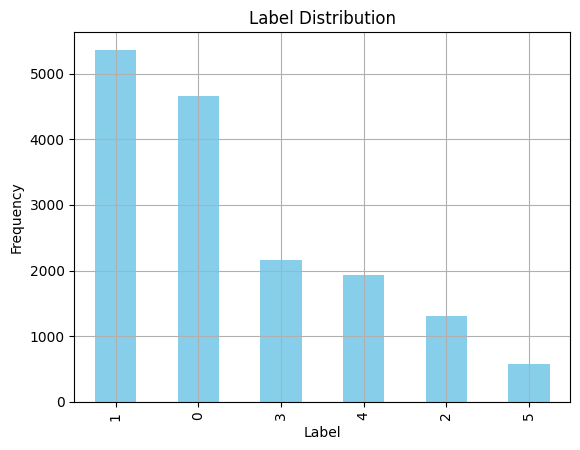

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.read_csv("/training.csv")
train_df['label'].value_counts().plot(kind='bar', title='Label Distribution', color='skyblue')
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Upsample Minority Classes

<Axes: title={'center': 'Balanced Label Distribution'}, xlabel='label'>

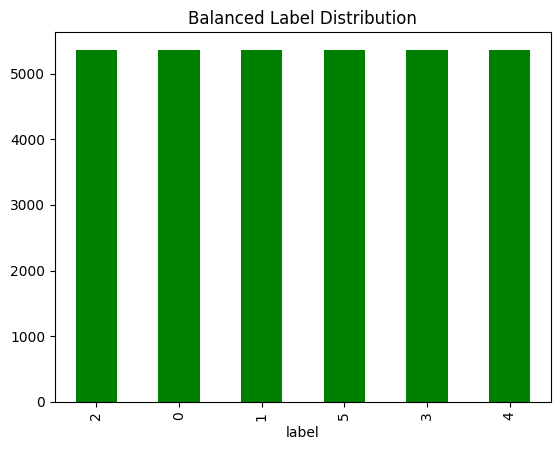

In [25]:
from sklearn.utils import resample

# Separate majority and minority classes
max_count = train_df['label'].value_counts().max()
balanced_dfs = []

# Upsample each class to match the majority count
for label in train_df['label'].unique():
    subset = train_df[train_df['label'] == label]
    upsampled = resample(subset, replace=True, n_samples=max_count, random_state=42)
    balanced_dfs.append(upsampled)

# Combine all upsampled classes
balanced_df = pd.concat(balanced_dfs)

# Shuffle the new dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new distribution
balanced_df['label'].value_counts().plot(kind='bar', title='Balanced Label Distribution', color='green')

# Tokenize + Prepare Input

In [27]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Features and labels
texts = balanced_df['text'].astype(str).values
labels = balanced_df['label'].values

# Tokenization
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=100)

# Label encoding
le = LabelEncoder()
y = le.fit_transform(labels)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and Train the LSTM Model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Model architecture
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(np.unique(y)), activation='softmax'))

# Compile
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


403/403 ━━━━━━━━━━━━━━━━━━━━ 112s 270ms/step - accuracy: 0.3368 - loss: 1.5227 - val_accuracy: 0.8830 - val_loss: 0.3880
Epoch 2/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 135s 252ms/step - accuracy: 0.9123 - loss: 0.2857 - val_accuracy: 0.9535 - val_loss: 0.1547
Epoch 3/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 138s 243ms/step - accuracy: 0.9658 - loss: 0.1157 - val_accuracy: 0.9601 - val_loss: 0.1444
Epoch 4/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 156s 278ms/step - accuracy: 0.9766 - loss: 0.0831 - val_accuracy: 0.9638 - val_loss: 0.1457
Epoch 5/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 131s 250ms/step - accuracy: 0.9859 - loss: 0.0507 - val_accuracy: 0.9742 - val_loss: 0.1008
Epoch 6/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 142s 251ms/step - accuracy: 0.9885 - loss: 0.0389 - val_accuracy: 0.9753 - val_loss: 0.0904
Epoch 7/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 139s 245ms/step - accuracy: 0.9893 - loss: 0.0344 - val_accuracy: 0.9734 - val_loss: 0.0921
Epoch 8/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 143s 249ms/step - accuracy: 0.9906 - loss: 0.03

In [31]:
# === Save the trained model ===
model.save("emotion_model.h5")
print("✅ Model saved as emotion_model.h5")

# === Save the tokenizer ===
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("✅ Tokenizer saved as tokenizer.pkl")

# === Save proper label map ===
label_map = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}
with open("label_map.pkl", "wb") as f:
    pickle.dump(label_map, f)
print("✅ Label map saved as label_map.pkl")

✅ Model saved as emotion_model.h5
✅ Tokenizer saved as tokenizer.pkl
✅ Label map saved as label_map.pkl


In [32]:
from google.colab import files

files.download("emotion_model.h5")
files.download("tokenizer.pkl")
files.download("label_map.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>